This notebook is part of the `deepcell-tf` documentation: https://deepcell.readthedocs.io/.

# Training a segmentation model

`deepcell-tf` leverages [Jupyter Notebooks](https://jupyter.org) in order to train models. Example notebooks are available for most model architectures in the [notebooks folder](https://github.com/vanvalenlab/deepcell-tf/tree/master/notebooks). Most notebooks are structured similarly to this example and thus this notebook serves as a core reference for the deepcell approach to model training.

In [2]:
import os
import errno

import numpy as np

import deepcell

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.6/dist-packages/deepcell/utils/__init__.py:49: UserWarning: To use `compute_overlap`, the C extensions must be built using `python setup.py build_ext --inplace`
  warnings.warn('To use `compute_overlap`, the C extensions must be built '


## Load the data

### Download the data from `deepcell.datasets`

`deepcell.datasets` provides access to a set of annotated live-cell imaging datasets which can be used for training cell segmentation and tracking models.
All dataset objects share the `load_data()` method, which allows the user to specify the name of the file (`path`), the fraction of data reserved for testing (`test_size`) and a `seed` which is used to generate the random train-test split.
Metadata associated with the dataset can be accessed through the `metadata` attribute.

In [3]:
# Download the data (saves to ~/.keras/datasets)
filename = 'HeLa_S3.npz'
test_size = 0.1 # % of data saved as test
seed = 0 # seed for random train-test split

(X_train, y_train), (X_test, y_test) = deepcell.datasets.hela_s3.load_data(
    filename, test_size=test_size, seed=seed)

6370107392/6370099814 [==============================] - 157s 0us/step


The `PanopticNet` models require square inputs. Reshape the data to meet the model requirements.

In [4]:
from deepcell.utils.data_utils import reshape_matrix

size = 128

X_train, y_train = reshape_matrix(X_train, y_train, reshape_size=size)
X_test, y_test = reshape_matrix(X_test, y_test, reshape_size=size)
print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

Reshaped feature data from (6480, 216, 256, 1) to (25920, 128, 128, 1)
Reshaped training data from (6480, 216, 256, 1) to (25920, 128, 128, 1)
Reshaped feature data from (720, 216, 256, 1) to (2880, 128, 128, 1)
Reshaped training data from (720, 216, 256, 1) to (2880, 128, 128, 1)
X.shape: (25920, 128, 128, 1)
y.shape: (25920, 128, 128, 1)


## Set up filepath constants


In [7]:
# change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

# DATA_FILE should be a npz file, preferably from `make_training_data`
DATA_FILE = os.path.join(DATA_DIR, filename)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [8]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

## Create the PanopticNet Model

Here we instantiate a `PanopticNet` model from `deepcell.model_zoo` using 3 semantic heads:
inner distance (1 class),
outer distance (1 class),
foreground/background distance (2 classes)

In [ ]:
from deepcell.model_zoo.panopticnet import PanopticNet

model = PanopticNet(
    backbone='resnet50',
    input_shape=X_train.shape[1:],
    norm_method='std',
    num_semantic_heads=3,
    num_semantic_classes=[1, 1, 2], # inner distance, outer distance, fgbg
    location=True,  # should always be true
    include_top=True)

## Prepare for training

### Set up training parameters.

There are a number of tunable hyper parameters necessary for training deep learning models:

**model_name**: Incorporated into any files generated during the training process.

**backbone**: The majority of DeepCell models support a variety backbone choices specified in the "backbone" parameter. Backbones are provided through [keras_applications](https://github.com/keras-team/keras-applications) and can be instantiated with weights that are pretrained on ImageNet.

**n_epoch**: The number of complete passes through the training dataset.

**lr**: The learning rate determines the speed at which the model learns. Specifically it controls the relative size of the updates to model values after each batch.

**optimizer**: The TensorFlow module [tf.keras.optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) offers optimizers with a variety of algorithm implementations. DeepCell typically uses the Adam or the SGD optimizers.

**lr_sched**: A learning rate scheduler allows the learning rate to adapt over the course of model training. Typically a larger learning rate is preferred during the start of the training process, while a small learning rate allows for fine-tuning during the end of training.

**batch_size**: The batch size determines the number of samples that are processed before the model is updated. The value must be greater than one and less than or equal to the number of samples in the training dataset.


In [9]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = 'watershed_centroid_nuclear_general_std_test'

n_epoch = 5  # Number of training epochs
test_size = .20  # % of data saved as test
norm_method = 'whole_image'  # data normalization

optimizer = Adam(lr=1e-5, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-5, decay=0.99)

batch_size = 1

min_objects = 3  # throw out images with fewer than this many objects

### Create the DataGenerators

The `SemanticDataGenerator` can output any number of transformations for each image. These transformations are passed to `generator.flow()` as a list of transform names.

Here we use `"inner-distance"`, `"outer-distance"` and `"fgbg"` to correspond to the inner distance, outer distance, and foreground background semantic heads, respectively. Keyword arguments may also be passed to each transform as a `dict` of transform names to `kwargs`.

In [ ]:
from deepcell import image_generators
from deepcell.utils import train_utils

transforms = ['inner-distance', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0}}


# use augmentation for training but not validation
datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.SemanticDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)
    
train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

Visualize the data generator output.

In [ ]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]

fig, axes = plt.subplots(1, 4, figsize=(15, 15))

axes[0].imshow(img[..., 0])
axes[0].set_title('Source Image')

axes[1].imshow(inner_distance[0, ..., 0])
axes[1].set_title('Inner Distance')

axes[2].imshow(outer_distance[0, ..., 0])
axes[2].set_title('Outer Distance')

axes[3].imshow(fgbg[0, ..., 0])
axes[3].set_title('Foreground/Background')

plt.show()

In [ ]:
inputs[0].shape

### Create a loss function for each semantic head

Each semantic head is trained with it's own loss function. Mean Square Error is used for regression-based heads, whereas `weighted_categorical_crossentropy` is used for classification heads.

The losses are saved as a dictionary and passed to `model.compile`.

In [12]:
# Create a dictionary of losses for each semantic head
from tensorflow.python.keras.losses import MSE
from deepcell import losses


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

In [13]:
model.compile(loss=loss, optimizer=optimizer)

## Train the model

Call `fit_generator` on the compiled model, along with a default set of callbacks.

In [ ]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus


model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    tensorboard_log_dir=LOG_DIR,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = model.fit_generator(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
 1225/11333 [==>...........................] - ETA: 5:21 - loss: 0.0070 - semantic_0_loss: 0.0026 - semantic_1_loss: 0.0035 - semantic_2_loss: 9.1718e-04
Epoch 00001: val_loss improved from inf to 0.00700, saving model to /data/models/watershed_centroid_nuclear_general_std_test.h5
11333/11333 [==============================] - 1305s 115ms/step - loss: 0.0481 - semantic_0_loss: 0.0260 - semantic_1_loss: 0.0207 - semantic_2_loss: 0.0014 - val_loss: 0.0070 - val_semantic_0_loss: 0.0026 - val_semantic_1_loss: 0.0035 - val_semantic_2_loss: 9.1687e-04
Epoch 2/5
 1225/11333 [==>...........................] - ETA: 5:05 - loss: 0.0054 - semantic_0_loss: 0.0018 - semantic_1_loss: 0.0028 - semantic_2_loss: 8.2334e-04
Epoch 00002: val_loss improved from 0.00700 to 0.00540, saving model to /data/models/watershed_centroid_nuclear_general_std_test.h5
11333/11333 [===============

## Predict on test data

Use the trained model to predict on new data. First, create a new prediction model without the foreground background semantic head. While this head is very useful during training, the output is unused during prediction. By using `model.load_weights(path, by_name=True)`, the semantic head can be removed.

In [5]:
from deepcell.model_zoo.panopticnet import PanopticNet

prediction_model = PanopticNet(
    backbone='resnet50',
    input_shape=X_train.shape[1:],
    norm_method='std',
    num_semantic_heads=2,
    num_semantic_classes=[1, 1], # inner distance, outer distance
    location=True,  # should always be true
    include_top=True)

In [10]:
model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
prediction_model.load_weights(model_path, by_name=True)

In [11]:
# make predictions on testing data
from timeit import default_timer

start = default_timer()
test_images = prediction_model.predict(X_test)
watershed_time = default_timer() - start

print('Watershed segmentation of shape', test_images[0].shape, 'in', watershed_time, 'seconds.')

Watershed segmentation of shape (2880, 128, 128, 1) in 7.923908749828115 seconds.


2360


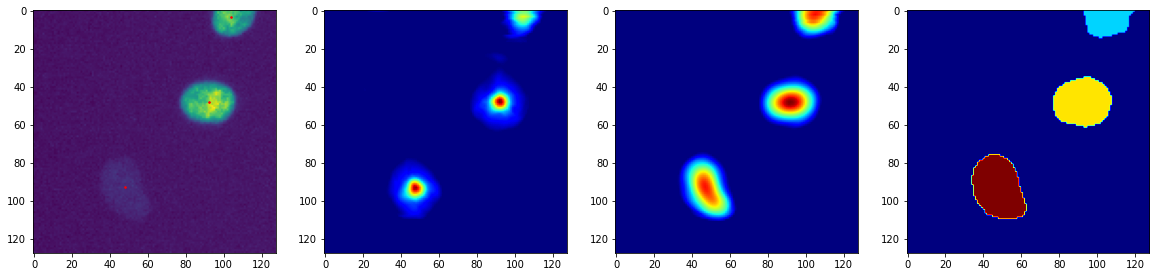

In [12]:
import time

from matplotlib import pyplot as plt
import numpy as np

from skimage.feature import peak_local_max

from deepcell_toolbox.deep_watershed import deep_watershed

index = np.random.choice(X_test.shape[0])
print(index)

fig, axes = plt.subplots(1, 4, figsize=(20, 20))

masks = deep_watershed(
    test_images,
    min_distance=10,
    detection_threshold=0.1,
    distance_threshold=0.01,
    exclude_border=False,
    small_objects_threshold=0)

# calculated in the postprocessing above, but useful for visualizing
inner_distance = test_images[0]
outer_distance = test_images[1]

coords = peak_local_max(
    inner_distance[index],
    min_distance=10,
    threshold_abs=0.1,
    exclude_border=False)

# raw image with centroid
axes[0].imshow(X_test[index, ..., 0])
axes[0].scatter(coords[..., 1], coords[..., 0],
                color='r', marker='.', s=10)

axes[1].imshow(inner_distance[index, ..., 0], cmap='jet')
axes[2].imshow(outer_distance[index, ..., 0], cmap='jet')
axes[3].imshow(masks[index, ...], cmap='jet')

plt.show()

## Evaluate results

The `deepcell.metrics` package is used to measure advanced metrics for instance segmentation predictions.

In [14]:
from deepcell_toolbox.metrics import Metrics
from skimage.morphology import watershed, remove_small_objects
from skimage.segmentation import clear_border

outputs = prediction_model.predict(X_test)

y_pred = []

for i in range(outputs[0].shape[0]):

    mask = deep_watershed(
        [t[[i]] for t in outputs],
        min_distance=10,
        detection_threshold=0.1,
        distance_threshold=0.01,
        exclude_border=False,
        small_objects_threshold=0)

    y_pred.append(mask[0])

y_pred = np.stack(y_pred, axis=0)
y_pred = np.expand_dims(y_pred, axis=-1)
y_true = y_test.copy()

print('Shape of y_pred is {} and shape of y_true is {}'.format(y_pred.shape, y_true.shape))

print('DeepWatershed - Remove no pixels')
m = Metrics('DeepWatershed - Remove no pixels', seg=False)
m.calc_object_stats(y_true, y_pred)
print('\n')

for i in range(y_pred.shape[0]):
    y_pred[i] = remove_small_objects(y_pred[i].astype(int), min_size=100)
    y_true[i] = remove_small_objects(y_true[i].astype(int), min_size=100)

print('DeepWatershed - Remove objects < 100 pixels')
m = Metrics('DeepWatershed - Remove 100 pixels', seg=False)
m.calc_object_stats(y_true, y_pred)
print('\n')

Shape of y_pred is (2880, 128, 128, 1) and shape of y_true is (2880, 128, 128, 1)
DeepWatershed - Remove no pixels


/usr/local/lib/python3.6/dist-packages/deepcell_toolbox/metrics.py:104: UserWarning: DICE score is technically 1.0, but prediction and truth arrays are empty. 
  warnings.warn('DICE score is technically 1.0, '
/usr/local/lib/python3.6/dist-packages/deepcell_toolbox/metrics.py:112: RuntimeWarning: invalid value encountered in long_scalars
  dice = (2 * intersection.sum() / (pred.sum() + truth.sum()))
/usr/local/lib/python3.6/dist-packages/deepcell_toolbox/metrics.py:113: RuntimeWarning: invalid value encountered in long_scalars
  jaccard = intersection.sum() / union.sum()
/usr/local/lib/python3.6/dist-packages/deepcell_toolbox/metrics.py:114: RuntimeWarning: invalid value encountered in long_scalars
  precision = intersection.sum() / pred.sum()
/usr/local/lib/python3.6/dist-packages/deepcell_toolbox/metrics.py:115: RuntimeWarning: invalid value encountered in long_scalars
  recall = intersection.sum() / truth.sum()
/usr/local/lib/python3.6/dist-packages/deepcell_toolbox/metrics.py:116: 


____________Object-based statistics____________

Number of true cells:		 7155
Number of predicted cells:	 7050

Correct detections:  6068	Recall: 84.8078266946191519082276499830186367034912109375%
Incorrect detections: 982	Precision: 86.070921985815601829017396084964275360107421875%

Gained detections: 939	Perc Error: 47.2096530920060359903800417669117450714111328125%
Missed detections: 1010	Perc Error: 50.77928607340371769396369927562773227691650390625%
Merges: 37		Perc Error: 1.860231271995977930799881505663506686687469482421875%
Splits: 3		Perc Error: 0.1508295625942684681231042986837564967572689056396484375%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 3
Missed detections from merges: 37
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.776515052030112062908528969273902475833892822265625 





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?


DeepWatershed - Remove objects < 100 pixels

____________Object-based statistics____________

Number of true cells:		 6244
Number of predicted cells:	 6278

Correct detections:  5765	Recall: 92.328635490070467994883074425160884857177734375%
Incorrect detections: 513	Precision: 91.8286078368907254798614303581416606903076171875%

Gained detections: 473	Perc Error: 51.52505446623093376956603606231510639190673828125%
Missed detections: 408	Perc Error: 44.4444444444444428654605871997773647308349609375%
Merges: 34		Perc Error: 3.703703703703703720151452216668985784053802490234375%
Splits: 3		Perc Error: 0.326797385620915037396372326838900335133075714111328125%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 3
Missed detections from merges: 34
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.7953408147717180298741368460468947887420654296875 



